## Importing necessary libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense, Pipeline
from tensorflow.keras.models import Model

from tensorflow.keras.applications.mobilenet import MobileNet,preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

2025-10-26 19:21:22.382963: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-26 19:21:22.498246: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-26 19:21:22.561312: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-26 19:21:22.571151: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-26 19:21:22.646219: I tensorflow/core/platform/cpu_feature_guar

## Image Data Preprocessing

> **Data Loading**

In [2]:
img_h = 224
img_w = 224
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

train_ds = image_dataset_from_directory("images/data/train",
                                        image_size=(img_h, img_w),
                                        batch_size=batch_size,
                                        label_mode='categorical')

val_ds = image_dataset_from_directory("images/data/val",
                                      image_size=(img_h, img_w),
                                      batch_size=batch_size,
                                      label_mode='categorical')

test_ds = image_dataset_from_directory("images/data/test",
                                       image_size=(img_h, img_w),
                                       batch_size=batch_size,
                                       label_mode='categorical',
                                       shuffle=False)

Found 6225 files belonging to 11 classes.
Found 1092 files belonging to 11 classes.


I0000 00:00:1761486685.899378  160985 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-26 19:21:26.116695: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Found 3187 files belonging to 11 classes.


In [3]:
## Augmenting the training data

augment = Pipeline([tf.keras.layers.RandomRotation(0.2),
                    tf.keras.layers.RandomZoom(0.2),
                    tf.keras.layers.RandomFlip("horizontal")])

In [4]:
def prepare(ds, shuffle=False, apply_augment=False):
    ds = ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
    ds = ds.cache()
    if shuffle: 
        ds = ds.shuffle(1000) 
    if apply_augment: 
        ds = ds.map(lambda x, y: (augment(x, training=True), y), num_parallel_calls=AUTOTUNE)
    return ds.prefetch(buffer_size=AUTOTUNE)


train_fds = prepare(train_ds, shuffle=True, apply_augment=True)
val_fds = prepare(val_ds)
test_fds = prepare(test_ds)


## Model Training

> **Pre-trained MobileNet V1 Model**

In [5]:
# Loading pre-trained ResNet50 Model

base_model = MobileNet(weights="imagenet", 
                      include_top=False,
                      input_shape=(img_h, img_w, 3))

In [6]:
# Freeze all layers

base_model.trainable = False

In [7]:
base_model.summary()

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,228,864 (12.32 MB)

In [8]:
## Custom Building Pre-trained MobileNet Layers

pretrained_mobilenet_model = Sequential([
    Input(shape=(img_h, img_w, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(train_ds.class_names.__len__(), activation="softmax")])

In [9]:
early_stopping = EarlyStopping(monitor="val_loss",
                               patience=3,
                               restore_best_weights=True,
                               verbose=1)

checkpoint = ModelCheckpoint(filepath="Trained Models/best_model_mobilenet_pretune.keras",
                             monitor="val_loss",
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=True)

In [10]:
pretrained_mobilenet_model.compile(optimizer="adam",
                                   loss="categorical_crossentropy",
                                   metrics=["accuracy"])

bf_mobilenet_history = pretrained_mobilenet_model.fit(train_fds,
                                                      validation_data=val_fds,
                                                      epochs=5,
                                                      callbacks=[early_stopping, checkpoint])

Epoch 1/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.4234 - loss: 1.9657
Epoch 1: val_loss improved from None to 0.27403, saving model to Trained Models/best_model_mobilenet_pretune.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 81s 398ms/step - accuracy: 0.6087 - loss: 1.2371 - val_accuracy: 0.9478 - val_loss: 0.2740
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.8444 - loss: 0.4662
Epoch 2: val_loss improved from 0.27403 to 0.16077, saving model to Trained Models/best_model_mobilenet_pretune.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 73s 370ms/step - accuracy: 0.8627 - loss: 0.4129 - val_accuracy: 0.9643 - val_loss: 0.1608
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.9066 - loss: 0.2771
Epoch 3: val_loss improved from 0.16077 to 0.10411, saving model to Trained Models/best_model_mobilenet_pretune.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 73s 371ms/step - accuracy: 0.9094 - loss: 0.2692 - val_accuracy: 0.9808 - val_loss: 0.1041
Epoch 4/5
195/195 ━━━━━━━━━━

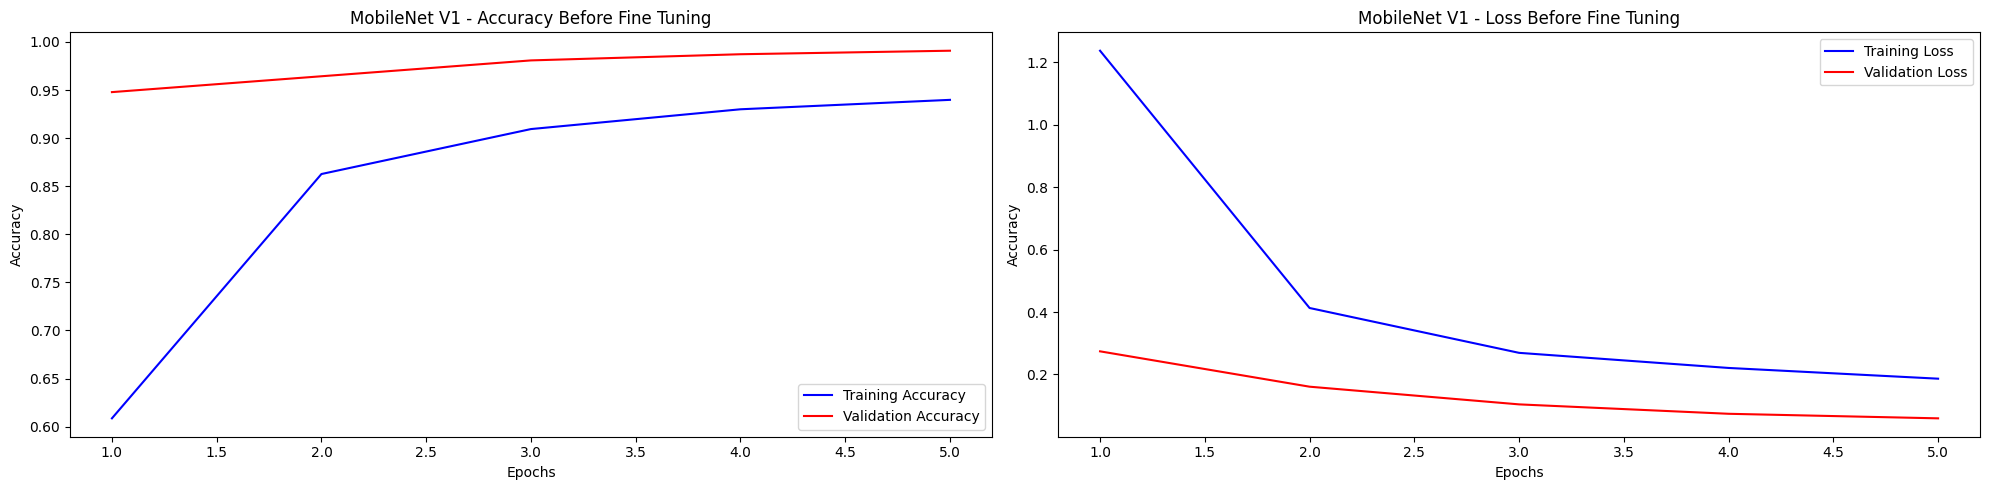

In [12]:
bf_train_accuracy = bf_mobilenet_history.history['accuracy']
bf_train_loss = bf_mobilenet_history.history['loss']

bf_val_accuracy = bf_mobilenet_history.history['val_accuracy']
bf_val_loss = bf_mobilenet_history.history['val_loss']

bf_epochs = range(1, len(bf_train_accuracy)+1)


plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(bf_epochs, bf_train_accuracy, 'b-', label='Training Accuracy')
plt.plot(bf_epochs, bf_val_accuracy, 'r-', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("MobileNet V1 - Accuracy Before Fine Tuning")

plt.subplot(1,2,2)
plt.plot(bf_epochs, bf_train_loss, 'b-', label='Training Loss')
plt.plot(bf_epochs, bf_val_loss, 'r-', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("MobileNet V1 - Loss Before Fine Tuning")

plt.tight_layout()
plt.show()

In [13]:
## Loading unseen test model(before fine-tuning)

model = tf.keras.models.load_model("Trained Models/best_model_mobilenet_pretune.keras")

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 11)             │        11,275 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,262,691 (12.45 MB)

 Trainable params: 11,275 (44.04 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

 Optimizer params: 22,552 (88.10 KB)

In [15]:
## Unfreezing the last few layers

for layer in base_model.layers[-19:]:
    layer.trainable = True

In [16]:
check_point1 = ModelCheckpoint(filepath="Trained Models/best_mobilnet_model_finetuned.keras",
                              monitor="val_loss",
                              save_best_only=True,
                              save_weights_only=False,
                              verbose=1)

In [17]:
pretrained_mobilenet_model.compile(optimizer=Adam(learning_rate=1e-5),
                                   loss="categorical_crossentropy",
                                   metrics=["accuracy"])

mobilenet_history = pretrained_mobilenet_model.fit(train_fds,
                                                  validation_data=val_fds,
                                                  epochs=10,
                                                  callbacks=[early_stopping, check_point1])

Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.4322 - loss: 2.5331
Epoch 1: val_loss improved from None to 0.13165, saving model to Trained Models/best_mobilnet_model_finetuned.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 104s 516ms/step - accuracy: 0.5375 - loss: 1.9127 - val_accuracy: 0.9707 - val_loss: 0.1316
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.7577 - loss: 0.7879
Epoch 2: val_loss improved from 0.13165 to 0.11228, saving model to Trained Models/best_mobilnet_model_finetuned.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 97s 498ms/step - accuracy: 0.7987 - loss: 0.6499 - val_accuracy: 0.9762 - val_loss: 0.1123
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.8760 - loss: 0.3957
Epoch 3: val_loss improved from 0.11228 to 0.08187, saving model to Trained Models/best_mobilnet_model_finetuned.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 100s 512ms/step - accuracy: 0.8904 - loss: 0.3506 - val_accuracy: 0.9826 - val_loss: 0.0819
Epoch 3: early stopp

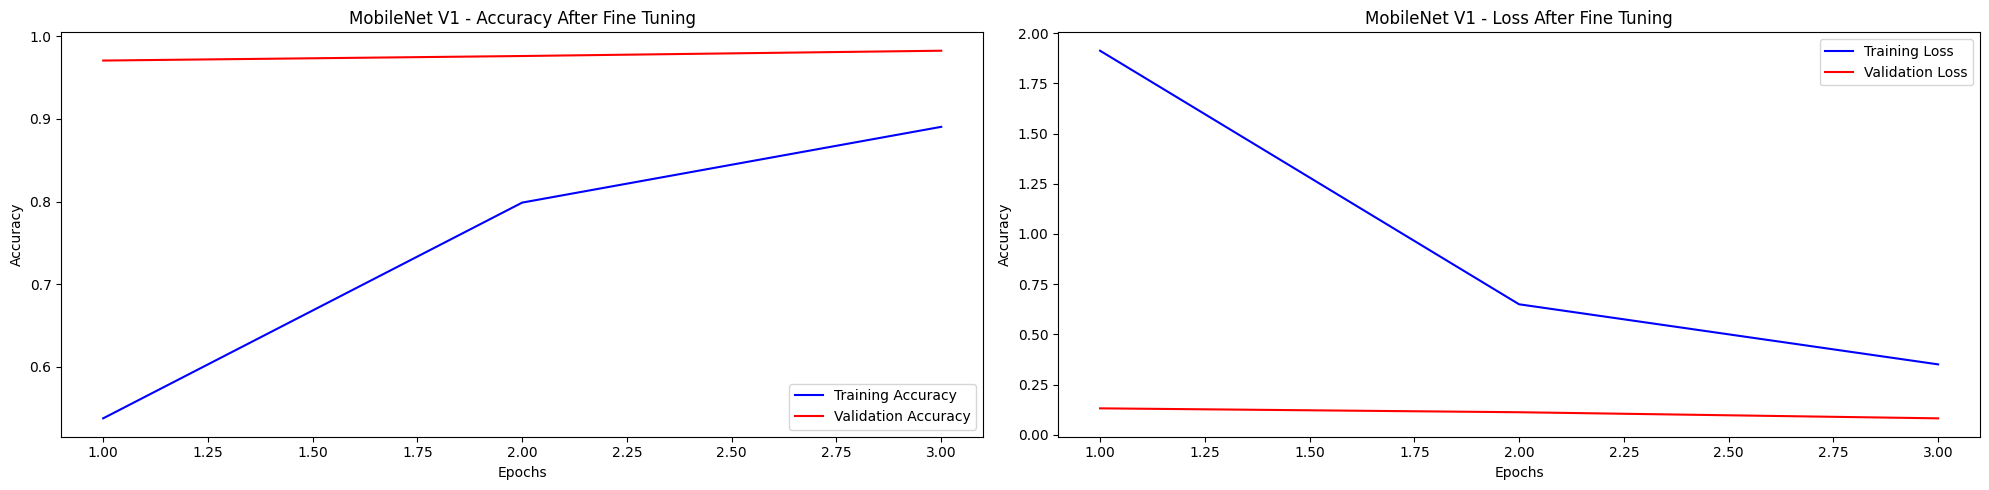

In [19]:
train_accuracy = mobilenet_history.history['accuracy']
train_loss = mobilenet_history.history['loss']

val_accuracy = mobilenet_history.history['val_accuracy']
val_loss = mobilenet_history.history['val_loss']

epochs = range(1, len(train_accuracy)+1)

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("MobileNet V1 - Accuracy After Fine Tuning")

plt.subplot(1,2,2)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("MobileNet V1 - Loss After Fine Tuning")

plt.tight_layout()
plt.show()

In [20]:
# Evaluating model based on accuracy

mobilenet_loss, mobilenet_accuracy = pretrained_mobilenet_model.evaluate(test_fds)
mobilenet_accuracy

100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 313ms/step - accuracy: 0.9746 - loss: 0.1036


0.9745842218399048

In [23]:
# Getting Predictions Probabilities and Predicted Classes

y_probs = pretrained_mobilenet_model.predict(test_fds)
y_pred = np.argmax(y_probs, axis=1)

100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 308ms/step


In [24]:
## Getting True Classes

y_true_list = []
for _, label_batch in test_fds:
    y_true_list.extend(label_batch.numpy().tolist())
y_true = np.argmax(y_true_list, axis=1)

2025-10-26 19:44:49.900369: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [25]:
print(y_pred.shape)
print(y_true.shape)

(3187,)
(3187,)


In [26]:
# Other Performance Metrics Calculations

mobilenet_precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
mobilenet_recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
mobilenet_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
mobilenet_cm = confusion_matrix(y_true, y_pred)

print("MobileNet Model - After FineTuning Performance Metrics:\n")
print(f" Accuracy : {mobilenet_accuracy*100:.4f}%")
print(f" Loss     : {mobilenet_loss:.4f}")
print(f" Precision: {mobilenet_precision:.4f}")
print(f" Recall   : {mobilenet_recall:.4f}")
print(f" F1 Score : {mobilenet_f1:.4f}")

MobileNet Model - After FineTuning Performance Metrics:

 Accuracy : 97.4584%
 Loss     : 0.1036
 Precision: 0.9714
 Recall   : 0.9746
 F1 Score : 0.9722


In [27]:
classes = {class_name : index for index, class_name in enumerate(test_ds.class_names)}
print(classes)

{'animal fish': 0, 'animal fish bass': 1, 'fish sea_food black_sea_sprat': 2, 'fish sea_food gilt_head_bream': 3, 'fish sea_food hourse_mackerel': 4, 'fish sea_food red_mullet': 5, 'fish sea_food red_sea_bream': 6, 'fish sea_food sea_bass': 7, 'fish sea_food shrimp': 8, 'fish sea_food striped_red_mullet': 9, 'fish sea_food trout': 10}


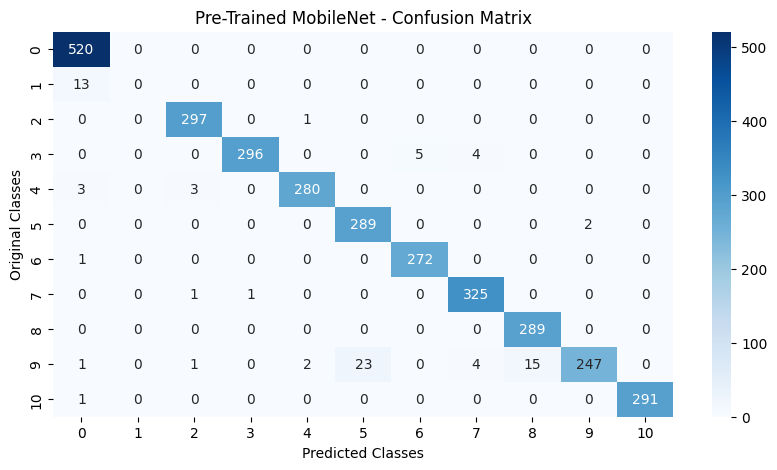

In [28]:
plt.figure(figsize=(10,5))
sns.heatmap(mobilenet_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Classes")
plt.ylabel("Original Classes")
plt.title("Pre-Trained MobileNet - Confusion Matrix")
plt.show()

In [29]:
# Classification Report (per-class)

mobilenet_cr = classification_report(y_true, y_pred, target_names=classes, zero_division=0)
print(mobilenet_cr)

                                  precision    recall  f1-score   support

                     animal fish       0.96      1.00      0.98       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.98      1.00      0.99       298
   fish sea_food gilt_head_bream       1.00      0.97      0.98       305
   fish sea_food hourse_mackerel       0.99      0.98      0.98       286
        fish sea_food red_mullet       0.93      0.99      0.96       291
     fish sea_food red_sea_bream       0.98      1.00      0.99       273
          fish sea_food sea_bass       0.98      0.99      0.98       327
            fish sea_food shrimp       0.95      1.00      0.97       289
fish sea_food striped_red_mullet       0.99      0.84      0.91       293
             fish sea_food trout       1.00      1.00      1.00       292

                        accuracy                           0.97      3187
                       macro avg    